# پیش بینی 

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import cv2
import numpy as np
import sys, os

def get_image (max = 0):
  # root = '/content/drive/MyDrive/RecycleIT/DATA/YOLO_imgs'
  root = '/content/drive/MyDrive/RecycleIT/DATA/data/modified_yolo_drinking_water_classification'
  for path, subdirs, files in os.walk(root):
    files = [ os.path.join(path, fi) for fi in files if  fi.endswith(".jpg") ]
    if (max==0) : max = min(len(files),max)
    for f in files[:max] :
      image_path = os.path.join(root, f)
      im = cv2.imread(image_path)
      im = cv2.resize(im, (640,640)) 
      im = im.astype(np.float32)
      im = im.T
      # yield (im , image_path)
      yield im , image_path
      # yield image_path

##  ‌اینفرنس روی CPU

In [ ]:
!pip uninstall onnxruntime      #if onnxruntime-gpu is installed 
!pip install onnxruntime	      # CPU build

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 15.3 MB/s 
     |████████████████████████████████| 46 kB 3.2 MB/s 
     |████████████████████████████████| 86 kB 5.6 MB/s 


In [ ]:
import onnxruntime

sparsified_yolo5_onnx_model = '/content/drive/MyDrive/RecycleIT/MODEL/yolo5_sparssified/epoch60.onnx'
yolo5_onnx_model = '/content/drive/MyDrive/RecycleIT/MODEL/yolo5/best1.onnx'
yolo7_onnx_model_exported_by_myself = '/content/drive/MyDrive/RecycleIT/MODEL/yolov7/best_2(exported_by_myself).onnx'
yolo7_onnx_model_exported_by_FP     = '/content/drive/MyDrive/RecycleIT/MODEL/yolov7/best_2(exported_by_FP).onnx'



In [ ]:
onnxruntime.get_device()

'CPU'

In [ ]:
def get_output(onnx_model):

    options = onnxruntime.SessionOptions()
    options.enable_profiling=True

    session = onnxruntime.InferenceSession(onnx_model,
                                          sess_options=options,
                                          providers=onnxruntime.get_available_providers()
                                          #  providers=['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']
                                            )
    print(onnxruntime.get_available_providers())

    input_name = session.get_inputs()[0].name
    print("input name", input_name)
    input_shape = session.get_inputs()[0].shape
    print("input shape", input_shape)
    input_type = session.get_inputs()[0].type
    print("input type", input_type)

    output_name = session.get_outputs()[0].name
    print("output name", output_name)
    output_shape = session.get_outputs()[0].shape
    print("output shape", output_shape)
    output_type = session.get_outputs()[0].type
    print("output type", output_type)

    # %time session.run([output_name], {input_name: [im]} )
    return session , input_name , output_name

In [ ]:
import pandas as pd

def get_inference(onnx_model): 
  df = pd.DataFrame(columns=('category', 'time', 'desc' ,'std'))
  session_time =  %timeit -o session, input_name , output_name = get_output(onnx_model)
  i = len(df)
  df.loc[i] = ['create_session',session_time.average , session_time.stdev , '']
  session, input_name , output_name = get_output(sparsified_yolo5_onnx_model)
  for img, img_path in get_image(200):
    m = %timeit -o session.run([output_name], {input_name: [img]} )
    i = len(df)
    df.loc[i] = ['inference',m.average , m.stdev , img_path]

  del session
  return df

In [ ]:
import matplotlib.pyplot as plt

def draw_plot(df , title ):

  plt.figure(figsize=(10,4),dpi=200)
  plt.plot(range(len(df)),df['time']*1000) #تبدیل ثانیه ب میلی ثانیه 
  plt.xlabel('number of image')
  plt.ylabel('Inference time (ms)')
  plt.title(title)

  plt.figure(figsize=(10,4),dpi=200)
  h = df['time'][1:]* 1000
  plt.hist(h,bins = 30)
  # plt.plot(x = range(len(int_time)),y = int_time)
  plt.xlabel('Inference time (ms)')
  plt.ylabel('Number of instances')
  plt.title(title)
  print(h.describe())

#  اینفرنس  یولو 5 اسپارس شده

In [ ]:
df = get_inference(sparsified_yolo5_onnx_model)
df.to_excel('/content/drive/MyDrive/RecycleIT/Report/sparsified_yolo5_onnx_model_on_CPU.xlsx')

['CPUExecutionProvider']
input name input
input shape [1, 3, 640, 640]
input type tensor(float)
output name out_0
output shape [1, 25200, 9]
output type tensor(float)
['CPUExecutionProvider']
input name input
input shape [1, 3, 640, 640]
input type tensor(float)
output name out_0
output shape [1, 25200, 9]
output type tensor(float)
['CPUExecutionProvider']
input name input
input shape [1, 3, 640, 640]
input type tensor(float)
output name out_0
output shape [1, 25200, 9]
output type tensor(float)
['CPUExecutionProvider']
input name input
input shape [1, 3, 640, 640]
input type tensor(float)
output name out_0
output shape [1, 25200, 9]
output type tensor(float)
['CPUExecutionProvider']
input name input
input shape [1, 3, 640, 640]
input type tensor(float)
output name out_0
output shape [1, 25200, 9]
output type tensor(float)
['CPUExecutionProvider']
input name input
input shape [1, 3, 640, 640]
input type tensor(float)
output name out_0
output shape [1, 25200, 9]
output type tensor(float

count    200.000000
mean     345.880550
std       18.352310
min      337.020027
25%      340.997814
50%      343.439391
75%      345.240581
max      527.513955
Name: time, dtype: float64


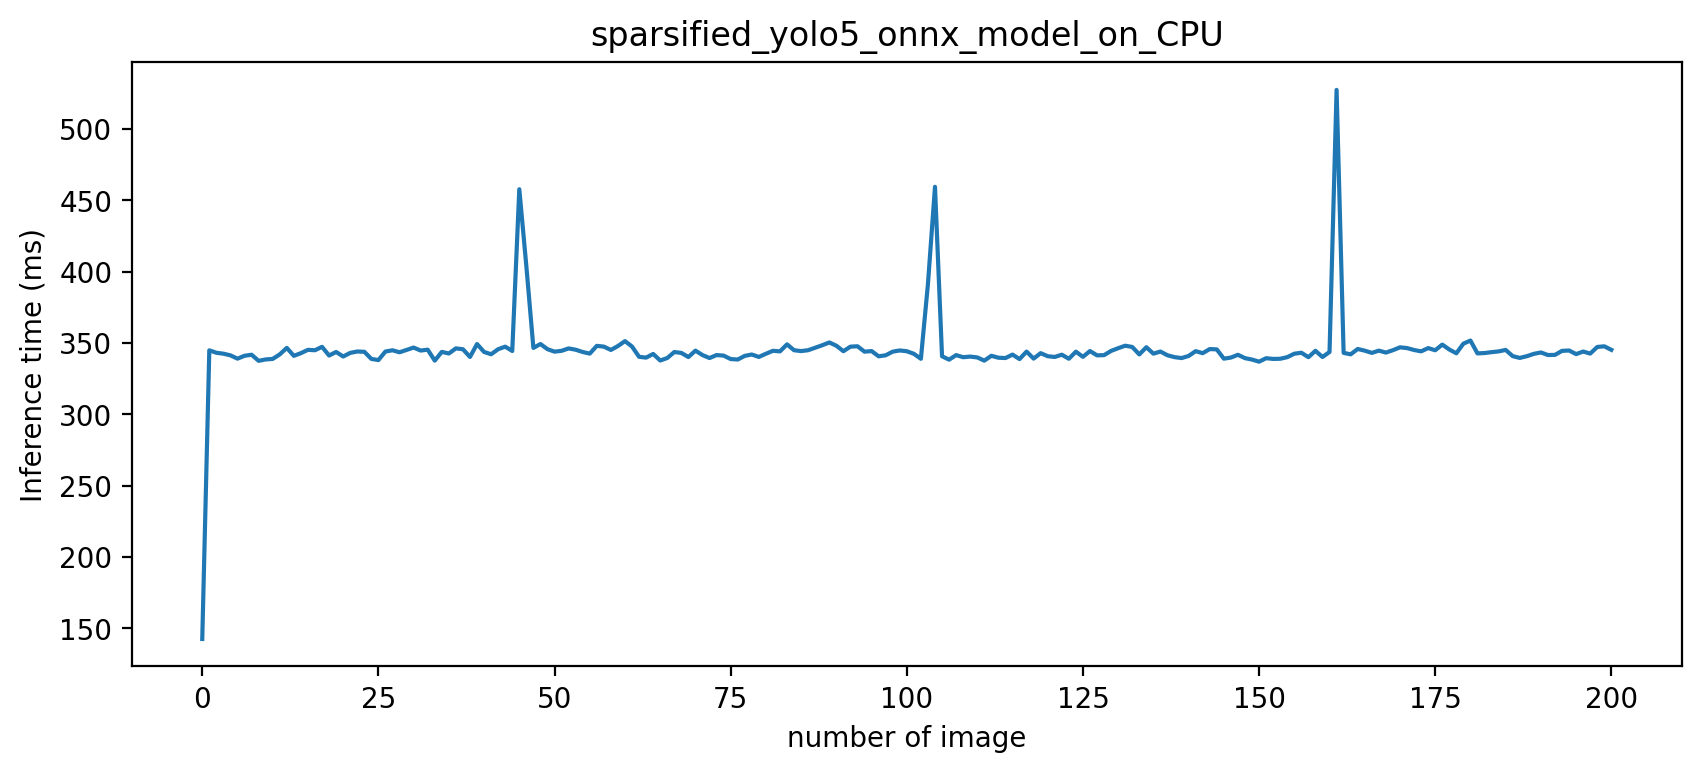

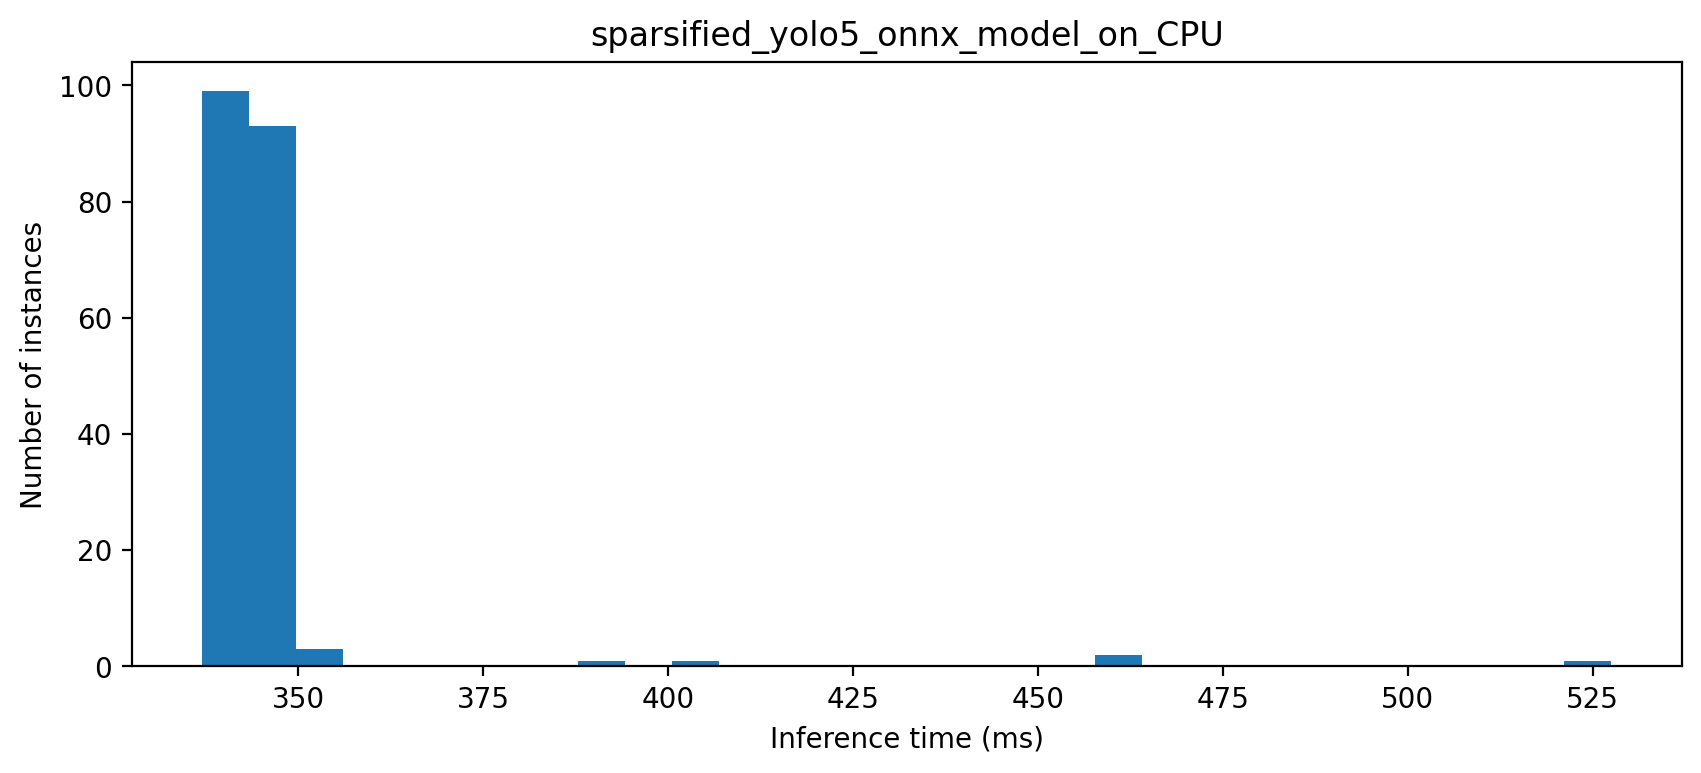

In [ ]:
# df = pd.read_excel('/content/drive/MyDrive/RecycleIT/Report/sparsified_yolo5_onnx_model_on_CPU.xlsx')
draw_plot(df, 'sparsified_yolo5_onnx_model_on_CPU')

In [ ]:
print(df.iloc[0,:])
df['min'] = df['time']-df['desc']
df['max'] = df['time']+df['desc']
df.describe()

category    create_session
time              0.142642
desc              0.007338
std                       
Name: 0, dtype: object


,time,desc,min,max
count,201.000000,201.000000,201.000000,201.000000
mean,0.344869,0.006719,0.338150,0.351589
std,0.023251,0.010666,0.019825,0.030261
min,0.142642,0.001909,0.135304,0.149981
25%,0.340897,0.003929,0.335612,0.345541
50%,0.343405,0.004962,0.338118,0.348621
75%,0.345237,0.006337,0.340495,0.350894
max,0.527514,0.085350,0.517368,0.544937


# محاسبه اینفرنس برای یولو 5 معمولی

In [ ]:
%%time
df = get_inference(yolo5_onnx_model)
df.to_excel('/content/drive/MyDrive/RecycleIT/Report/yolo5_onnx_model_on_CPU.xlsx')

['CPUExecutionProvider']
input name images
input shape [1, 3, 640, 640]
input type tensor(float)
output name output0
output shape [1, 25200, 9]
output type tensor(float)
['CPUExecutionProvider']
input name images
input shape [1, 3, 640, 640]
input type tensor(float)
output name output0
output shape [1, 25200, 9]
output type tensor(float)
['CPUExecutionProvider']
input name images
input shape [1, 3, 640, 640]
input type tensor(float)
output name output0
output shape [1, 25200, 9]
output type tensor(float)
['CPUExecutionProvider']
input name images
input shape [1, 3, 640, 640]
input type tensor(float)
output name output0
output shape [1, 25200, 9]
output type tensor(float)
['CPUExecutionProvider']
input name images
input shape [1, 3, 640, 640]
input type tensor(float)
output name output0
output shape [1, 25200, 9]
output type tensor(float)
['CPUExecutionProvider']
input name images
input shape [1, 3, 640, 640]
input type tensor(float)
output name output0
output shape [1, 25200, 9]
output

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/RecycleIT/Report/yolo5_onnx_model_on_CPU.xlsx')
print(df.iloc[0,:])
df['min'] = df['time']-df['desc']
df['max'] = df['time']+df['desc']
df.describe()

Unnamed: 0                 0
category      create_session
time                0.128203
desc                0.004608
std                      NaN
Name: 0, dtype: object


,Unnamed: 0,time,desc,min,max
count,201.000000,201.000000,201.000000,201.000000,201.000000
mean,100.000000,0.345704,0.008976,0.336729,0.354680
std,58.167861,0.028220,0.017102,0.017500,0.043261
min,0.000000,0.128203,0.001211,0.123594,0.132811
25%,50.000000,0.340675,0.004339,0.334577,0.345498
50%,100.000000,0.342264,0.005315,0.336809,0.347898
75%,150.000000,0.344587,0.006823,0.339292,0.350681
max,200.000000,0.529103,0.148811,0.422836,0.677913


count    401.000000
mean     361.317933
std       47.405872
min      182.106305
25%      338.365004
50%      352.777499
75%      364.187977
max      762.141844
Name: time, dtype: float64


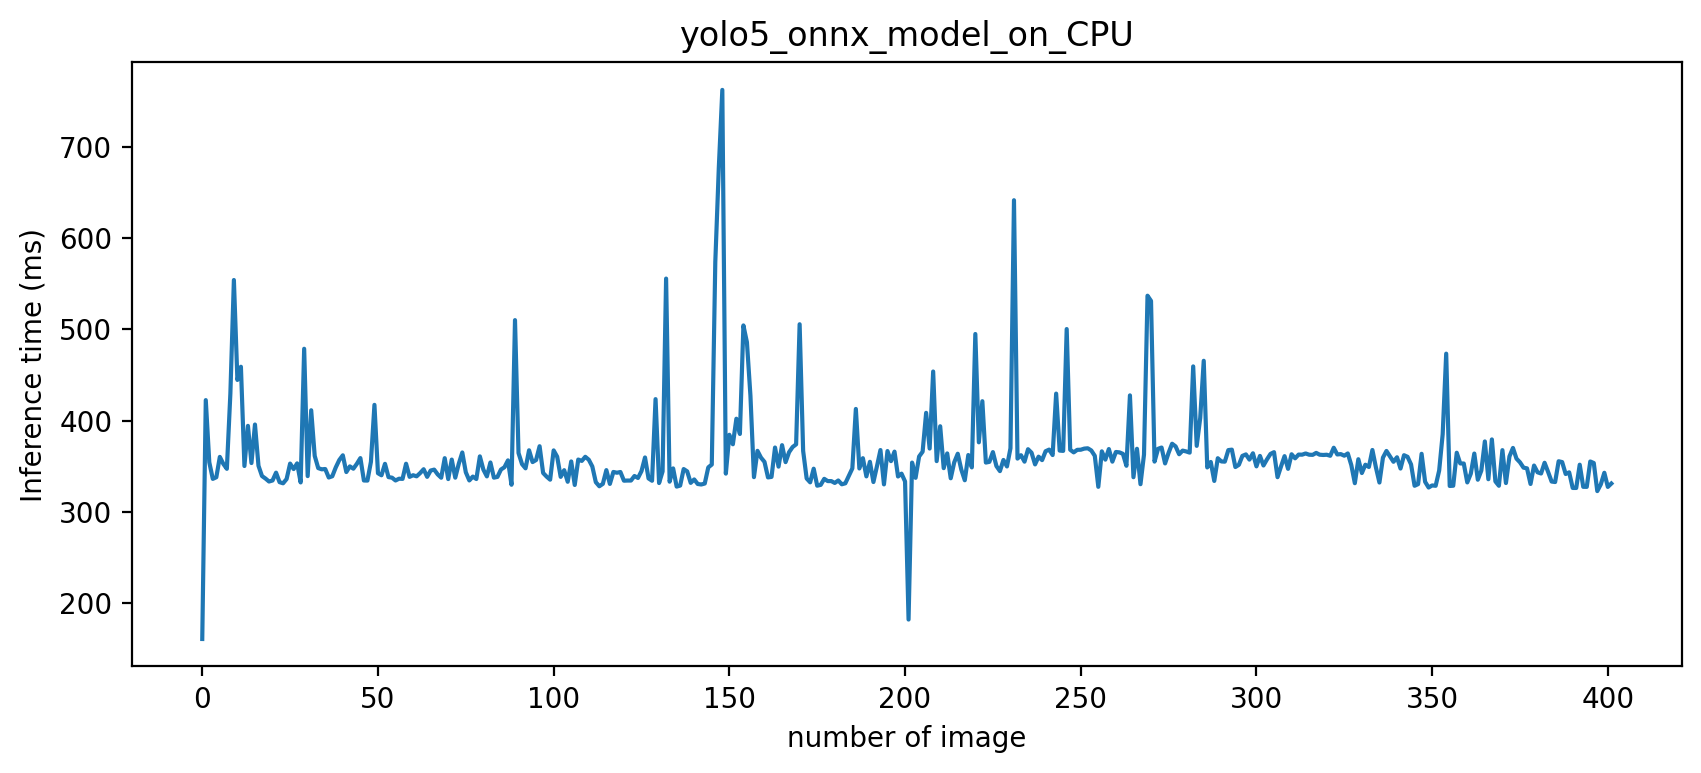

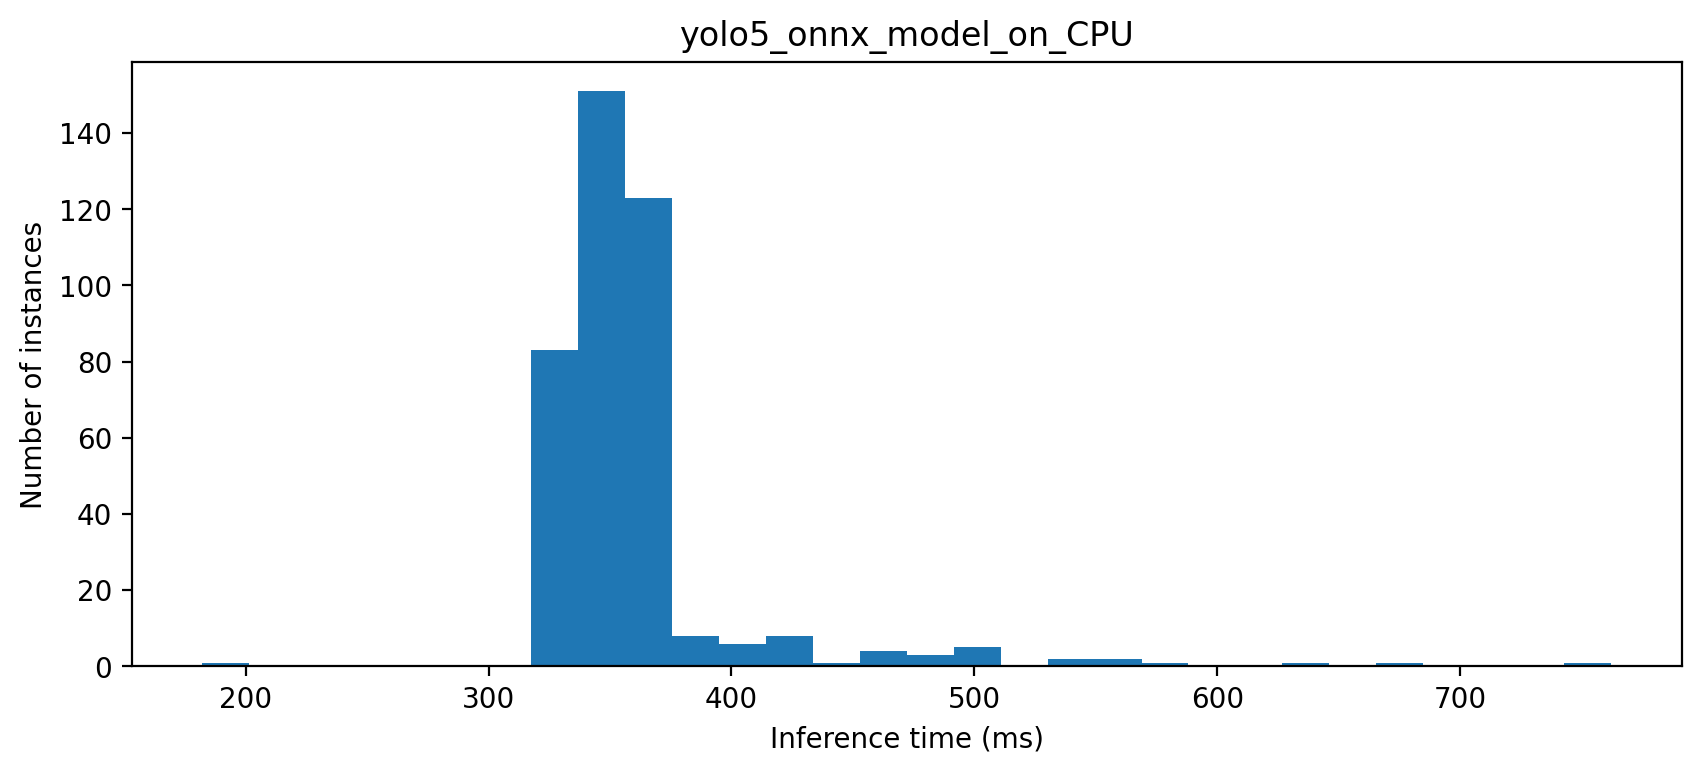

In [ ]:
draw_plot(df , 'yolo5_onnx_model_on_CPU')

# محاسبه اینفرنس برای یولو 7 اکسپورت شده ف پ

In [ ]:
%%time
df = get_inference(yolo7_onnx_model_exported_by_FP)
df.to_excel('/content/drive/MyDrive/RecycleIT/Report/yolo7_onnx_model_Exported_byFP_on_CPU.xlsx')

['CPUExecutionProvider']
input name images
input shape [1, 3, 640, 640]
input type tensor(float)
output name output
output shape [1, 3, 80, 80, 9]
output type tensor(float)
['CPUExecutionProvider']
input name images
input shape [1, 3, 640, 640]
input type tensor(float)
output name output
output shape [1, 3, 80, 80, 9]
output type tensor(float)
['CPUExecutionProvider']
input name images
input shape [1, 3, 640, 640]
input type tensor(float)
output name output
output shape [1, 3, 80, 80, 9]
output type tensor(float)
['CPUExecutionProvider']
input name images
input shape [1, 3, 640, 640]
input type tensor(float)
output name output
output shape [1, 3, 80, 80, 9]
output type tensor(float)
['CPUExecutionProvider']
input name images
input shape [1, 3, 640, 640]
input type tensor(float)
output name output
output shape [1, 3, 80, 80, 9]
output type tensor(float)
['CPUExecutionProvider']
input name images
input shape [1, 3, 640, 640]
input type tensor(float)
output name output
output shape [1, 3,

In [ ]:
# df = pd.read_excel('/content/drive/MyDrive/RecycleIT/Report/yolo7_onnx_model_Exported_byFP_on_CPU.xlsx')
print(df.iloc[0,:])
df['min'] = df['time']-df['desc']
df['max'] = df['time']+df['desc']
df.describe()

category    create_session
time              1.177346
desc              0.104936
std                       
Name: 0, dtype: object


,time,desc,min,max
count,201.000000,201.000000,201.000000,201.000000
mean,0.367831,0.016284,0.351547,0.384115
std,0.073092,0.021743,0.062519,0.087873
min,0.329424,0.002191,0.281557,0.333073
25%,0.346165,0.006437,0.329600,0.362589
50%,0.360858,0.012413,0.341870,0.373597
75%,0.369601,0.016524,0.361892,0.378406
max,1.177346,0.147473,1.072410,1.282282


count    200.000000
mean     363.783211
std       45.384573
min      329.424213
25%      346.154248
50%      360.774174
75%      369.595105
max      767.872527
Name: time, dtype: float64


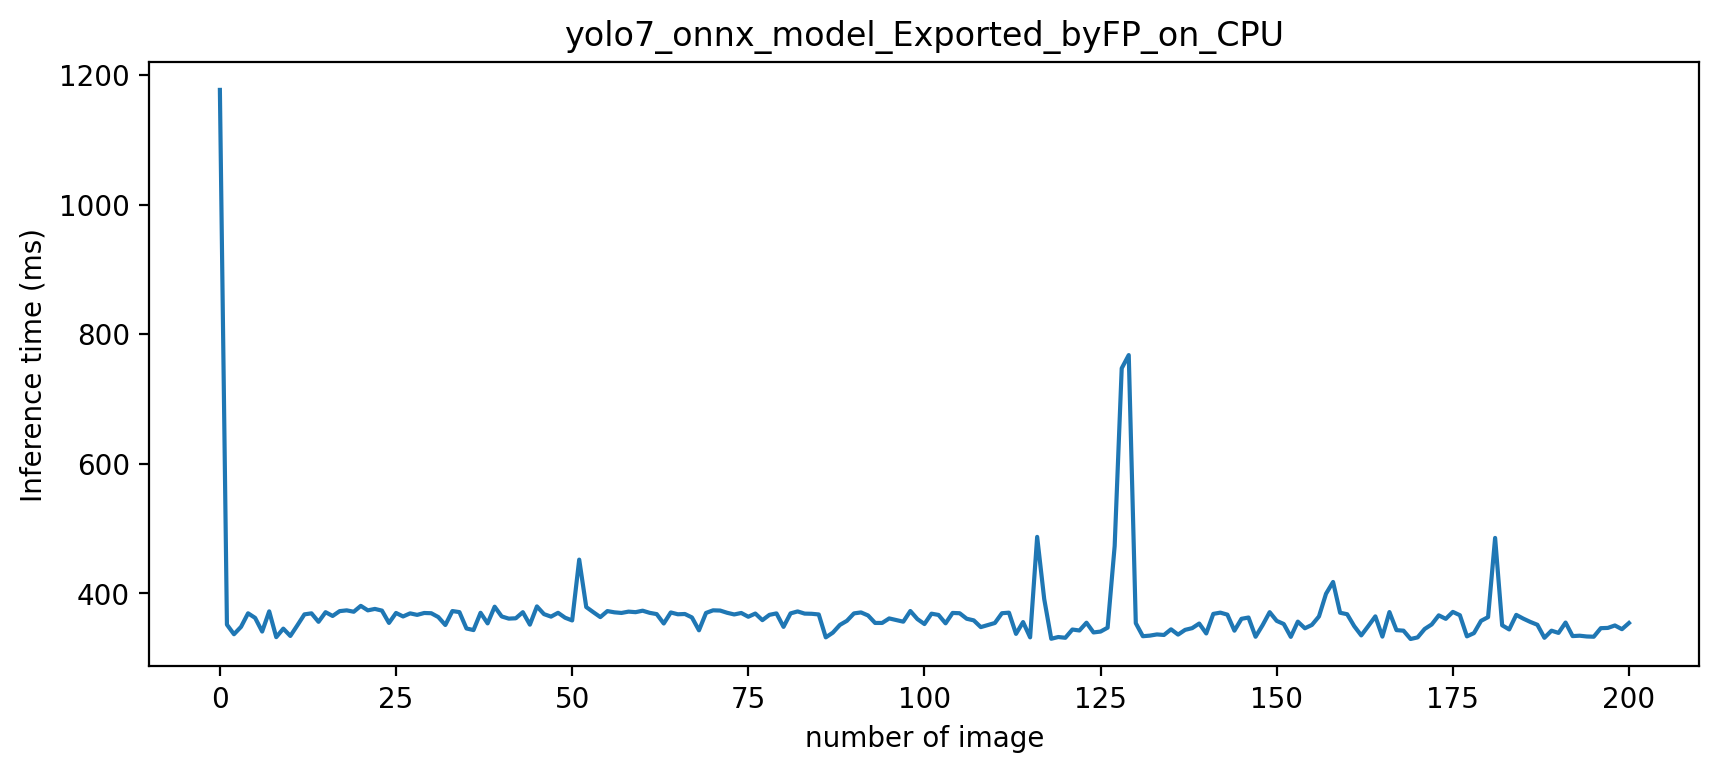

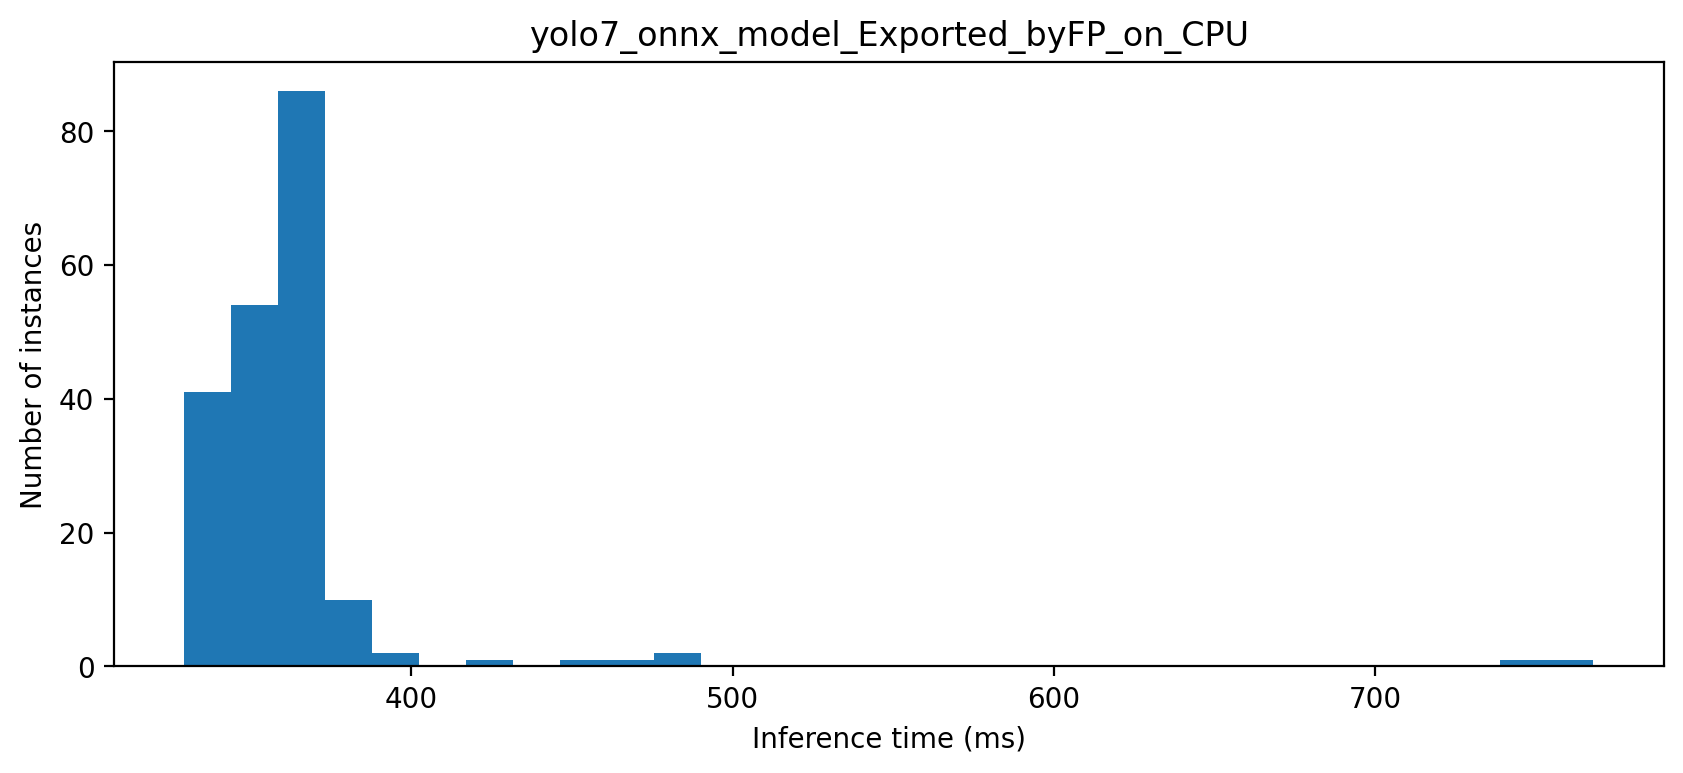

In [ ]:
draw_plot(df, 'yolo7_onnx_model_Exported_byFP_on_CPU')

# محاسبه اینفرنس برای یولو 7 اکسپورت شده خودم

In [ ]:
%%time
df = get_inference(yolo7_onnx_model_exported_by_myself)
df.to_excel('/content/drive/MyDrive/RecycleIT/Report/yolo7_onnx_model_Exported_byMP_on_CPU.xlsx')
# df = pd.read_excel('/content/drive/MyDrive/RecycleIT/Report/yolo7_onnx_model_Exported_byMP_on_CPU.xlsx')


['CPUExecutionProvider']
input name images
input shape [1, 3, 640, 640]
input type tensor(float)
output name output
output shape [1, 3, 80, 80, 9]
output type tensor(float)
['CPUExecutionProvider']
input name images
input shape [1, 3, 640, 640]
input type tensor(float)
output name output
output shape [1, 3, 80, 80, 9]
output type tensor(float)
['CPUExecutionProvider']
input name images
input shape [1, 3, 640, 640]
input type tensor(float)
output name output
output shape [1, 3, 80, 80, 9]
output type tensor(float)
['CPUExecutionProvider']
input name images
input shape [1, 3, 640, 640]
input type tensor(float)
output name output
output shape [1, 3, 80, 80, 9]
output type tensor(float)
['CPUExecutionProvider']
input name images
input shape [1, 3, 640, 640]
input type tensor(float)
output name output
output shape [1, 3, 80, 80, 9]
output type tensor(float)
['CPUExecutionProvider']
input name images
input shape [1, 3, 640, 640]
input type tensor(float)
output name output
output shape [1, 3,

TypeError: ignored

count    200.000000
mean     363.901385
std       27.482689
min      332.548935
25%      353.650914
50%      365.058668
75%      369.842781
max      660.521779
Name: time, dtype: float64


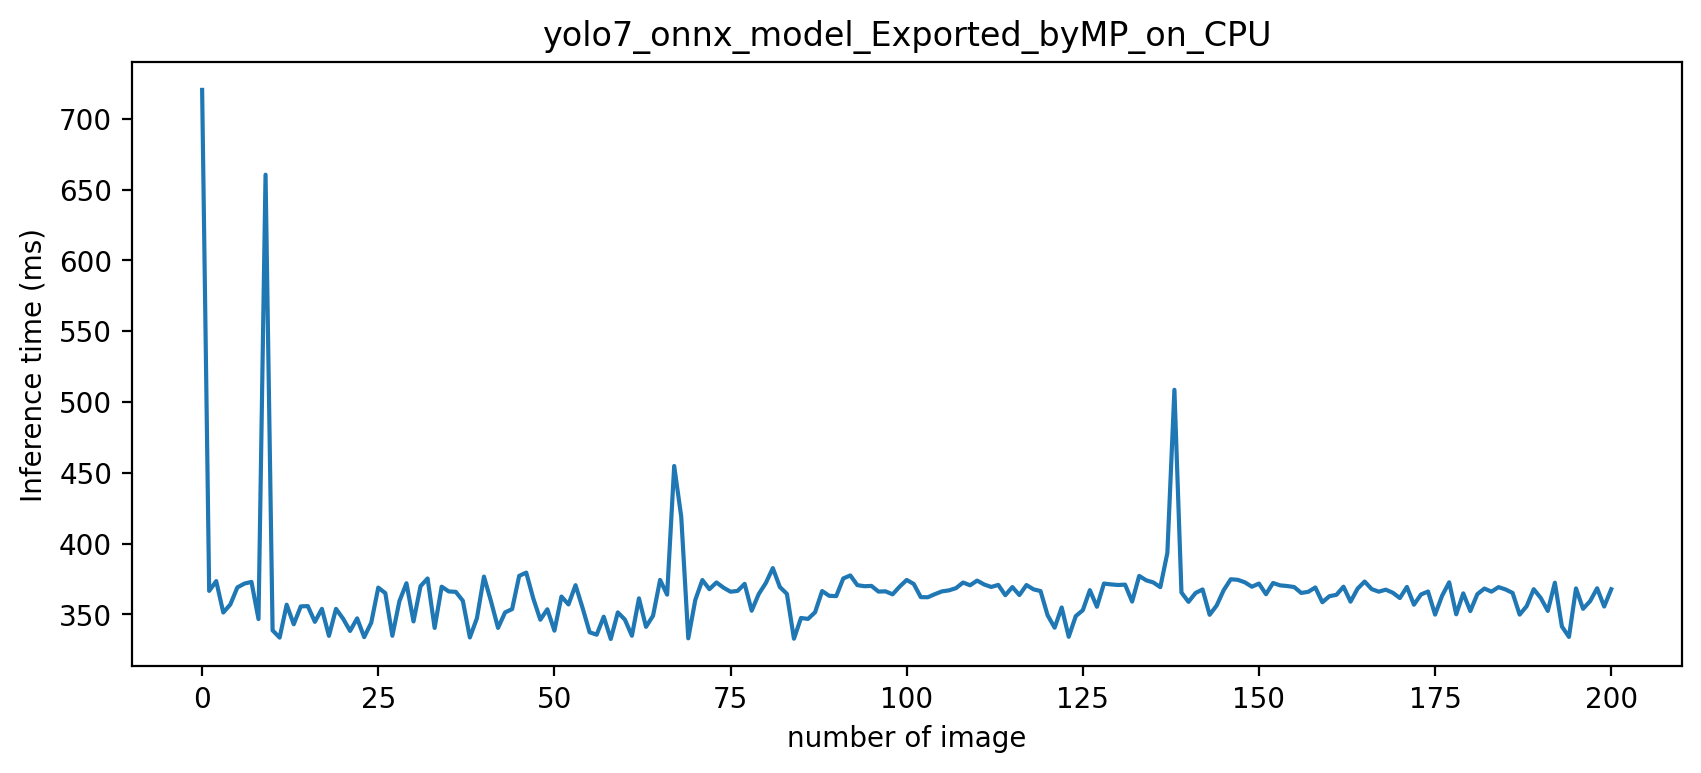

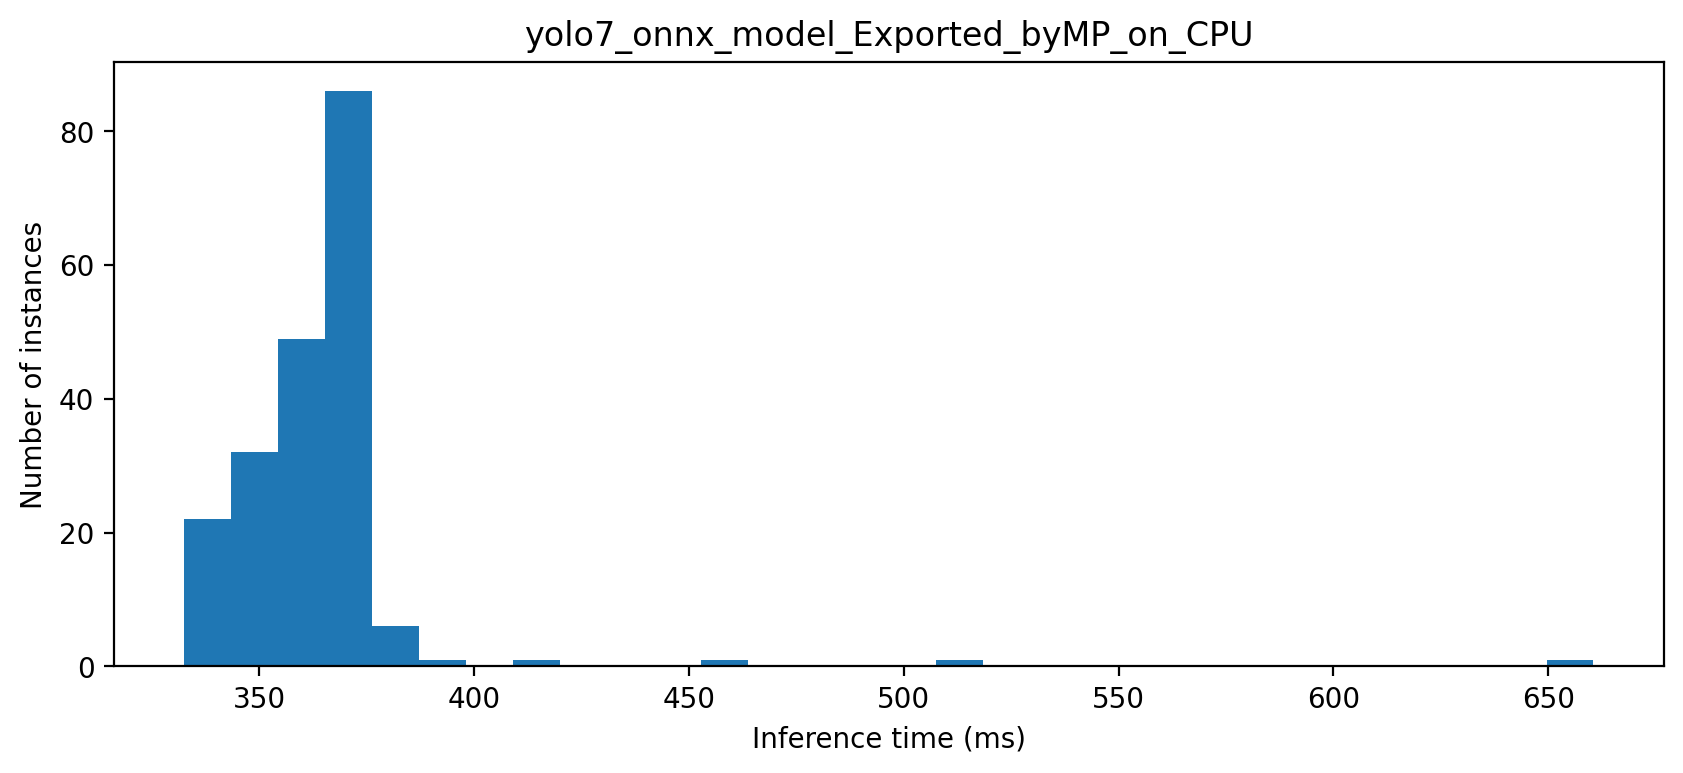

In [ ]:
draw_plot(df ,'yolo7_onnx_model_Exported_byMP_on_CPU')

In [ ]:
print(df.iloc[0,:])
df['min'] = df['time']-df['desc']
df['max'] = df['time']+df['desc']
df.describe()

category    create_session
time               0.72042
desc              0.068591
std                       
Name: 0, dtype: object


,time,desc,min,max
count,201.000000,201.000000,201.000000,201.000000
mean,0.365675,0.012376,0.353299,0.378051
std,0.037201,0.016142,0.028554,0.049735
min,0.332549,0.001897,0.315135,0.335173
25%,0.353694,0.005621,0.336758,0.368623
50%,0.365079,0.007675,0.357614,0.373427
75%,0.369871,0.015767,0.363609,0.377319
max,0.720420,0.160995,0.651828,0.821517
